In [25]:
%matplotlib inline

import random
import numpy as np
import collections

import matplotlib.pyplot as plt

from bandits_auxiliary import *

In [80]:
# mu is accumulative rewards.
#sigma is probablity distribution for playing each arm that is random

The game is the following:
        - we have k arms
        - at each timestamp t we can pick one arm
        - we receive a reward (a real number) 
        - our objective is to have a cumulative reward as high as possible

Problem: we don't know anything about the arms. Suppose the reward for each arm i is coming from a gaussian distribution N(mu_i, sigma): each time we choose arm i and we "play" it, then  we can only see a stochastic observation coming from N(mu_i, sigma). Which strategy can we follow? If we pick arm 3 and we get a reward of -10 for example, were we only unliky? Is arm 3 simply bad? And what does it mean "bad"? Are the other unexplored arms better? Or even worse?!

Let's try to find a good strategy!

In [27]:
class arm():
    def __init__(self,mu,sigma):
        self.mu = mu
        self.sigma = sigma


In [28]:
def initialize_arms(num_arms):
    mu_list = np.arange(0,num_arms)/10.
    sigma_list = list(1 for i in range(num_arms))
    arms = []
    for x in zip(mu_list, sigma_list):
        x = arm(x[0],x[1])
        arms.append(x)       
    random.Random(1).shuffle(arms)
    return arms

Some help:
    - the function "initialize_arms(n)" creates your n arms
    - if you want to play arm i you only need to use "random.gauss(arms[i].mu, arms[i].sigma)"       and the funcion will return to you the reward corresponding to arm i
    - at each time stamp you can also call an oracle (a function) "best_arm_reward(arms)" 
      which returns you a reward from the unknown best arm (we need it as a comparator for           measuring the regret

In [29]:
#fix a number of tasks (start with 20)
num_arms = 20
arms = initialize_arms(num_arms)

# Pure search 

Let's start we a (dumb) strategy: choose the arm randomly! 

In [30]:
#todo: at each t we randomly select an arm and we play it!
def best_arm_reward(arms, num=1):
    best_arm = arms[np.argmax([arms[i].mu for i in range(len(arms))])]
    if num==1:
        return random.gauss(best_arm.mu, best_arm.sigma) 
    else:
        return [random.gauss(best_arm.mu, best_arm.sigma) for j in range(num)]

In [37]:
#list of the sigle regrets in each timestamp
regret_list = []
#history of all our earnings
earnings_list = []
#every time we pick arm i we add 1 to arm_counter[i] (i.e length is num_arms)
arms_counter = np.zeros(num_arms)
#chronological list of the arms picked (it will have length T at the end)
list_chosen_arms = []
T=10000
for t in range(T):
    
    i = np.random.randint(20) #choose the arm i to play
    arms_counter[i] +=1
    reward = np.random.normal(arms[i].mu,arms[i].sigma)
    list_chosen_arms.append(i)
    
    
    earnings_list.append(reward)
    # remember: the regret is the difference between what you could have earned picking the
    # best arm and the reward you actually got picking arm i 
    bestreward= best_arm_reward(arms, num=1)
    regret = bestreward - reward
    regret_list.append(regret)

In [38]:
def display_results(arms, earnings_list, regret_list, T):    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,7))
    ax1 = axes[0]
    ax1.plot(range(T), earnings_list, label='Our earnings') 
    ax1.plot(range(T), np.cumsum(best_arm_reward(arms, T)),label='Optimal earnings') 
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Earnings')
    ax1.legend()

    ax2 = axes[1]
    ax2.plot(range(T), regret_list) 
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Regret')
    plt.show()

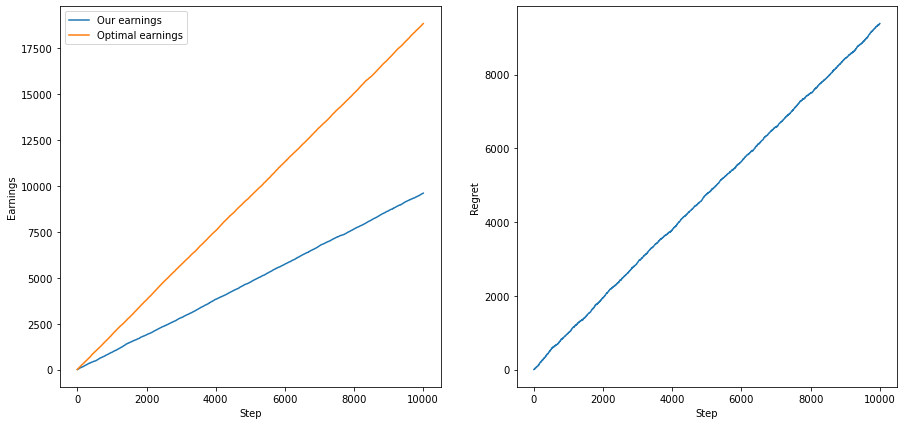

In [39]:
display_results(arms,np.cumsum(earnings_list),np.cumsum(regret_list),T)

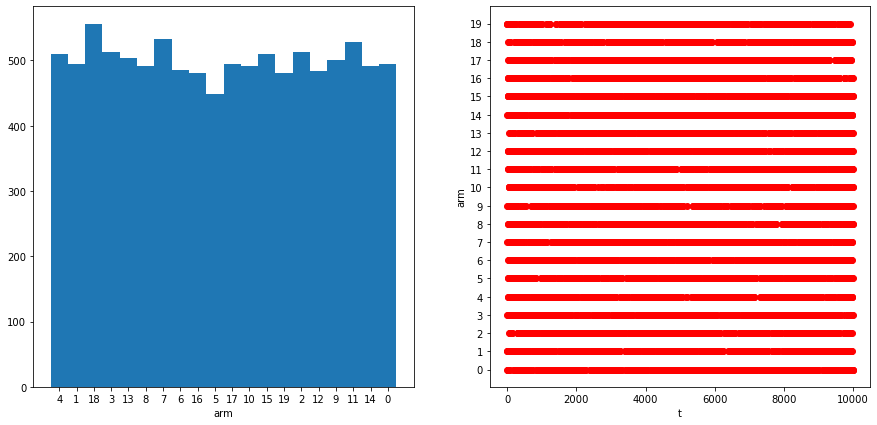

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,7))
#histogram showing how many times we picked the k-th arm
ax1 = axes[0]
ax1.bar(collections.Counter(list_chosen_arms).keys(), collections.Counter(list_chosen_arms).values(),1,tick_label=np.arange(num_arms))
ax1.set_xlabel("arm")
#plot showing our choices of the arms through time
ax2 = axes[1]
ax2.plot(list_chosen_arms,'ro')
ax2.set_yticks(range(num_arms))
ax2.set_xlabel("t")
ax2.set_ylabel("arm")
plt.show()

1) is our strategy working well? Explain your answer (hint: look at the plots and at the 
    regret in particular...)
2) imagine to have an infite horizon (T = +inf), do you expect some changes in the plots? 

### <font color="blueviolet">Comment and Analysis: <font color="navy"> Looking at regret plot we can see that in the initial steps, the regret is low as it is expected but when we start to play more and more the regret which is the difference between best reward and real reward starts to increase linearly.

### <font color="blueviolet">Comment and Analysis: <font color="navy"> Second observation is that when we increase the T , our  plots become completely linear without any flactuations and also in the case of bar plots the number of times that we pick each arm become more and more equal.

# Epsilon greedy

Let's try to slightly improve the strategy!

This time we want a compromise between pure exploration and exploitation, meaning that if on one hand we want to try all the arms multiple times to really understand which one is the best one, on the other we want also to exploit what we discover meanwhile and play multiple times the best arm we have seen so far 

Simple solution: toss a coin! At each timestamp we toss a biased coin (Prob(head)=epsilon,
Prob(tail)=1-epsilon) : if we get head we play the arm giving rewards with the higher estimated mean seen so far, if we get tail we simply pick an arm randomly and we play it! 
                                                                   

In [71]:
regret_list = []
earnings_list = []
list_chosen_arms = []


epsilon = 0.5

arms_counter= np.zeros(len(arms))

#estimated rewards mean for each arm -> keep it updated every time you see a new reward! (length= num_arms)
#hint: remember that since we have also negative rewards you cannot initialize it to a list with all zeros....
est_mean = [-np.inf for j in range(num_arms)]

for t in range(T):
    #how can you simulate a bised coin in python? think to uniform distribution in [0,1] 
    #(hint: np.random.rand()...)
    coin_flip = np.random.rand()
    if coin_flip < epsilon:
        reward=0
        i = np.random.randint(20)
        arms_counter[i] +=1
        reward =  np.random.normal(arms[i].mu,arms[i].sigma)
        if arms_counter[0]==1:
            est_mean[i] = reward    #the first time you play arm i you remove -inf and you put the first reward as estimated reward mean (mean of only one observation)
        else:
            est_mean[i] = est_mean[i] + reward    #how do you update dinamically the mean of arm i once you get a new reward from arm i? 
    else:
        #you want to pick the arm with best estimated reward mean so far, hint: np.argmax...
        i = np.argmax([a.mu for a in arms])
        
        arms_counter[i] +=1
        
        if arms_counter[i]==1:
            est_mean[i] = reward
        else:
            est_mean[i] = est_mean[i] + reward
    
    list_chosen_arms.append(i)
    earnings_list.append(reward)
    bestreward= best_arm_reward(arms, num=1)
    regret = bestreward - reward
    regret_list.append(regret)

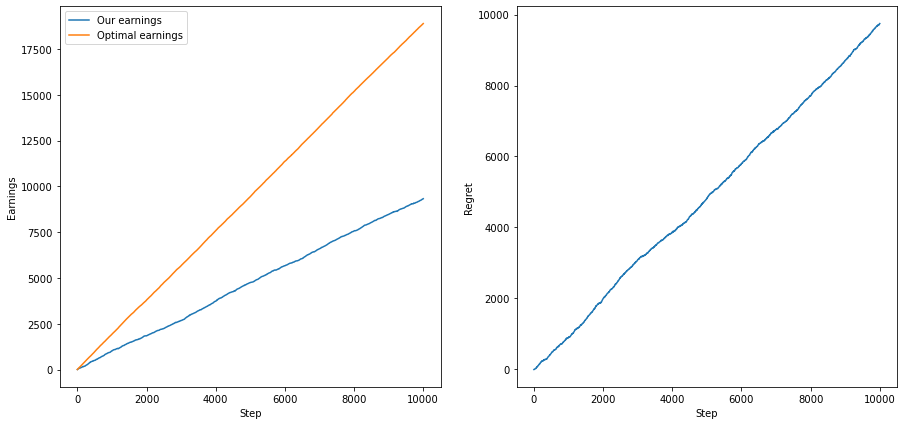

In [72]:
display_results(arms,np.cumsum(earnings_list),np.cumsum(regret_list),T)

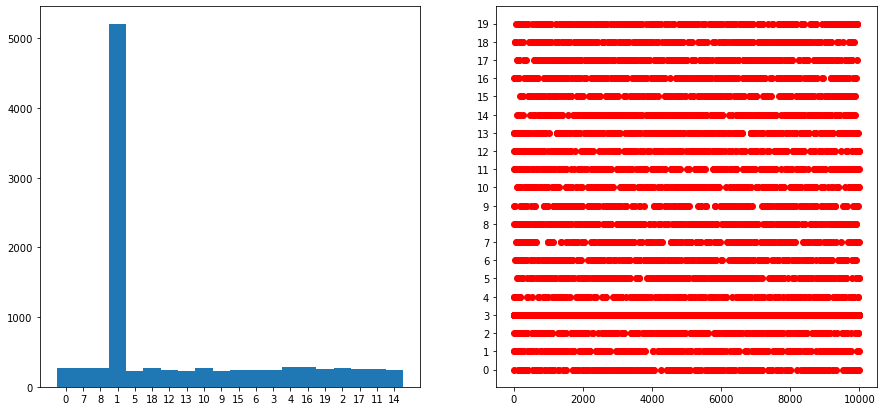

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,7))
ax1 = axes[0]
ax1.bar(collections.Counter(list_chosen_arms).keys(), collections.Counter(list_chosen_arms).values(),1,tick_label=np.arange(num_arms))
ax2 = axes[1]
ax2.plot(list_chosen_arms,'ro')
ax2.set_yticks(range(num_arms))
plt.show()

1) Play with epsilon to get good results!
2) Is this strategy better or worse than pure search?
3) About the optimization of episilon: can you think how to improve this strategy? hint: think to the weak spots of this algorithm, when T goes to +inf for example....
4) Which arm (1,2,...,20) is the best?

### <font color="blueviolet">Comment and Analysis: <font color="navy"> As you can see in this strategy, we did not play all the arms equally and we play some arms more than the others because it seems that they are giving us a better reward. for instance the first arm here has the most played arm label.

### <font color="blueviolet">Comment and Analysis: <font color="navy">  I think this is a better strategy because as we proceed we can see that by increasing T our plots for optimal and real reward are getting closerv and the regret is not linear anymore.

### <font color="blueviolet">Comment and Analysis: <font color="navy"> Below is the plot that compare different epsilons for epsilon greedt algorithm:

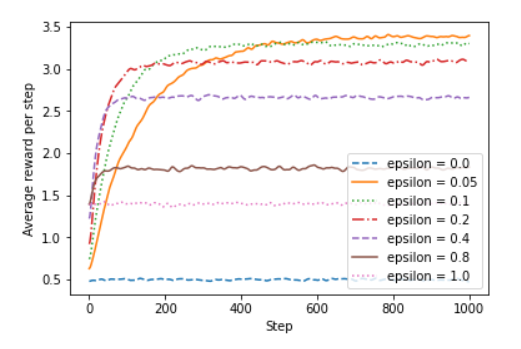

### <font color="blueviolet">Comment and Analysis: <font color="navy"> Asyou can see, higher values of epsilon tend to have a lower reward over time, except that we need some non-zero value of epsilon. Higher values mean more exploration, so the bandit spends more time exploring less valuable actions, even after it has a good estimate of the value of actions. The actual choice of the epsilon parameter is entirely dependent on the particular application: there is absulutely perfect number. However, as in this particular case, an epsilon between 0.05-0.1 is usually a reasonable choice.But we can also see that while epsilon = 0.05 ends up with a higher return after about 350 steps, initially it does not do as well as epsilon = 0.1, because it does not explore enough. 

## Upper band confidence

In [76]:
UCB_Values = np.inf*np.ones(num_arms) #initialize the UCB values for each arm to +inf
cum_reward_list = np.zeros(num_arms) #: at time t cum_reward_list[i] is the sum of all the rewards we got from arm i from time 0 to t
regret_list = []
earnings_list = []
list_chosen_arms = []
arms_counter = np.zeros(num_arms)
delta = 0.2

for t in range(T):
    
    i=np.argmax(UCB_Values)
    reward = np.random.normal(arms[i].mu,arms[i].sigma)
    cum_reward_list[i] = cum_reward_list[i] + reward
    arms_counter[i] +=1
    
    #update UCB_values following scheme of eq. 7.2
    UCB_Values[i] = (cum_reward_list[i]/arms_counter[i]) + delta * (np.sqrt(np.log(t)/arms_counter[i]))
    
    list_chosen_arms.append(i)
    earnings_list.append(reward)
    bestreward= best_arm_reward(arms, num=1)
    regret = bestreward - reward
    regret_list.append(regret)

   

<ipython-input-76-5ce3162b9f0e>:17: RuntimeWarning: divide by zero encountered in log
  UCB_Values[i] = (cum_reward_list[i]/arms_counter[i]) + delta * (np.sqrt(np.log(t)/arms_counter[i]))
<ipython-input-76-5ce3162b9f0e>:17: RuntimeWarning: invalid value encountered in sqrt
  UCB_Values[i] = (cum_reward_list[i]/arms_counter[i]) + delta * (np.sqrt(np.log(t)/arms_counter[i]))


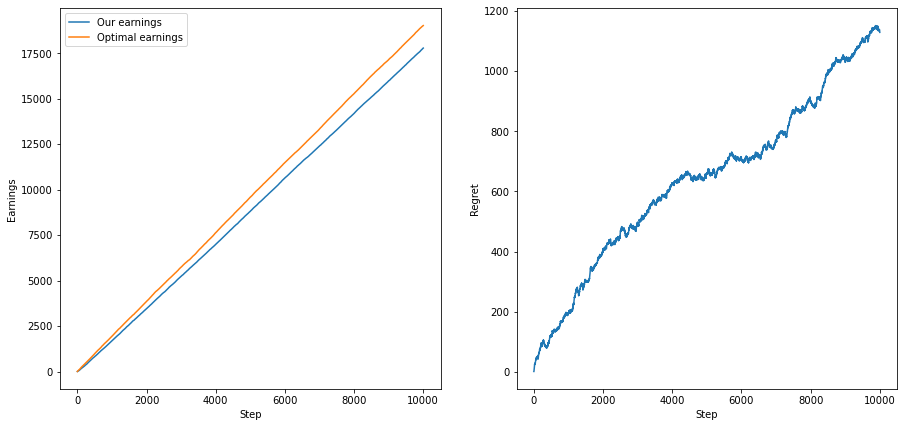

In [78]:
display_results(arms,np.cumsum(earnings_list),np.cumsum(regret_list),T)

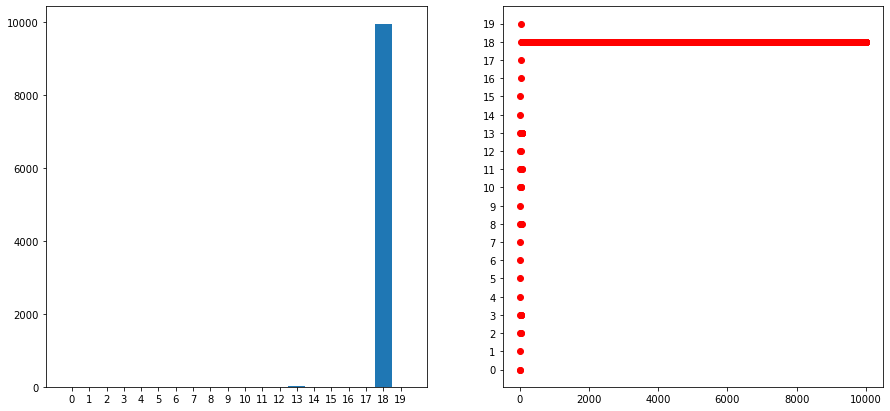

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,7))
ax1 = axes[0]
ax1.bar(collections.Counter(list_chosen_arms).keys(), collections.Counter(list_chosen_arms).values(),1,tick_label=np.arange(num_arms))
ax2 = axes[1]
ax2.plot(list_chosen_arms,'ro')
ax2.set_yticks(range(num_arms))
plt.show()

### <font color="blueviolet">Comment and Analysis: <font color="navy"> In this case as it was expected, our earning is becoming closer to the optimal one so we can claim that UCB is a better strategy for multi arm bandit problem. also in this case we can see that 18th arm is chosen as the best one amongst all.